<a href="https://colab.research.google.com/github/shreyassathyamangalam/colab_notebooks/blob/main/ensemble_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installations ##

In [1]:
!pip install great_tables

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.8/978.8 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 2.9 MB/s eta 0:00:00


In [2]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 8.7 MB/s eta 0:00:00


In [3]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.1 MB/s eta 0:00:00


In [4]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 9.6 MB/s eta 0:00:00


In [5]:
!pip install colorama

## Import libraries ##

In [6]:
# holy grail
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# statistics
import scipy
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

# hyperparameter tuning
import optuna

# category encoders
from category_encoders import OneHotEncoder, MEstimateEncoder, CatBoostEncoder, OrdinalEncoder
import category_encoders as ce

# gc
import gc

# sklearn
from sklearn import set_config
set_config(display='diagram')
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, train_test_split
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer, f1_score, accuracy_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    BaggingClassifier,
    HistGradientBoostingClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    StackingClassifier,
    VotingClassifier
)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier

# boosting models
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# warnings
import warnings
warnings.filterwarnings(action='ignore', category=Warning)

# others
from great_tables import  GT, style, exibble, from_column, loc
from colorama import Fore, Style

## Settings ##

In [7]:
sns.set_theme(style='white', palette='colorblind')
pal = sns.color_palette('colorblind')

set_config(transform_output='pandas')

pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Functions ##

In [8]:
def printColor(pText: str):
    print(f'{Style.BRIGHT}{Fore.GREEN}{pText}{Style.RESET_ALL}')

In [9]:
def printInfo():
    print(f'{Style.BRIGHT}{Fore.YELLOW}SHAPE{Style.RESET_ALL}')
    print(f'{Style.BRIGHT}{Fore.GREEN} train: {train.shape}')
    print(f'{Style.BRIGHT}{Fore.GREEN} test:  {test.shape}')
    #print(f'{Style.BRIGHT}{Fore.GREEN} original:  {original.shape}')
    print(f'{Style.BRIGHT}{Fore.YELLOW}\nNULL VALUES{Style.RESET_ALL}')
    print(f'{Style.BRIGHT}{Fore.GREEN} train: {train.isnull().any().any()}')
    print(f'{Style.BRIGHT}{Fore.GREEN} test: {test.isnull().any().any()}')
    #print(f'{Style.BRIGHT}{Fore.GREEN} original: {original.isnull().any().any()}')
    print(f'{Style.BRIGHT}{Fore.YELLOW}\nDUPLICATES{Style.RESET_ALL}')
    print(f'{Style.BRIGHT}{Fore.GREEN} train: {train.duplicated().any().any()}')
    print(f'{Style.BRIGHT}{Fore.GREEN} test: {test.duplicated().any().any()}')
    #print(f'{Style.BRIGHT}{Fore.GREEN} original: {original.duplicated().any().any()}')

In [10]:
def customStatistic(df: pd.DataFrame(), categoric = False):
    num_cols = list(df._get_numeric_data())
    cat_cols = list(df.drop(num_cols,axis=1))
    if categoric:
        desc = pd.DataFrame(index = list(df[cat_cols]))
        df = df[cat_cols]
    else:
        desc = pd.DataFrame(index = list(df[num_cols]))
        df = df[num_cols]
        desc['skew'] = df[num_cols].skew()

    desc['type'] = df.dtypes
    desc['count'] = df.count()
    desc['nunique'] = df.nunique()
    desc['%unique'] = desc['nunique'] /len(df) * 100
    desc['null'] = df.isnull().sum()
    desc['%null'] = desc['null'] / len(df) * 100
    desc = pd.concat([desc,df.describe().T.drop('count',axis=1)],axis=1)

    desc = desc.round(2)
    return desc.reset_index().rename(columns={'index':'Column'}).sort_values(by=['type'])

In [11]:
def min_max_unique(data_train, data_test):

    df = pd.DataFrame(index=data_train.columns)
    summary = {}
    for col in data_train.columns:
        if pd.api.types.is_numeric_dtype(data_train[col]):
            min_train = min(data_train[col])
            min_test = min(data_test[col])
            max_train = max(data_train[col])
            max_test = max(data_test[col])
            unique_train = len(data_train[col].unique())
            unique_test = len(data_test[col].unique())
            top5_train = sorted(data_train[col])[:5]
            top5_test = sorted(data_test[col])[:5]
        else:
            min_train = min_test = max_train = max_test = None
            unique_train = len(data_train[col].unique())
            unique_test = len(data_test[col].unique())
            top5_train = top5_test = None
        summary[col] = [min_train, min_test, max_train, max_test,
                        unique_train, unique_test]

    df = pd.DataFrame.from_dict(summary, orient='index', columns=['min_train', 'min_test', 'max_train', 'max_test',
                                                                  'unique_train', 'unique_test'])\
        .reset_index().rename(columns={'index': 'columns'})


    return df

## Import Data ##

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
!pwd

/content


In [14]:
!ls

drive  sample_data


In [15]:
!cd drive

In [16]:
!ls

drive  sample_data


In [17]:
!ls /content/drive/MyDrive/

 academic_success_project  'Colab Notebooks'   test.csv   train.csv


In [18]:
!ls /content/drive/MyDrive/academic_success_project/

sample_submission.csv  test.csv  train.csv


In [19]:
train = pd.read_csv('/content/drive/MyDrive/academic_success_project/train.csv')
test = pd.read_csv('/content/drive/MyDrive/academic_success_project/test.csv')
sub = pd.read_csv('/content/drive/MyDrive/academic_success_project/sample_submission.csv')

In [20]:
train.head()

,id,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Admission grade,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,International,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,0,1,1,1,9238,1,1,126.000,1,1,19,5,5,122.600,0,0,0,1,0,1,18,0,0,6,6,6,14.500,0,0,6,7,6,12.429,0,11.100,0.600,2.020,Graduate
1,1,1,17,1,9238,1,1,125.000,1,19,19,9,9,119.800,1,0,0,1,0,0,18,0,0,6,8,4,11.600,0,0,6,9,0,0.000,0,11.100,0.600,2.020,Dropout
2,2,1,17,2,9254,1,1,137.000,1,3,19,2,3,144.700,0,0,0,1,1,0,18,0,0,6,0,0,0.000,0,0,6,0,0,0.000,0,16.200,0.300,-0.920,Dropout
3,3,1,1,3,9500,1,1,131.000,1,19,3,3,2,126.100,1,0,0,1,0,1,18,0,0,7,9,7,12.591,0,0,8,11,7,12.820,0,11.100,0.600,2.020,Enrolled
4,4,1,1,2,9500,1,1,132.000,1,19,37,4,9,120.100,1,0,0,1,0,0,18,0,0,7,12,6,12.933,0,0,7,12,6,12.933,0,7.600,2.600,0.320,Graduate


In [21]:
test.head()

,id,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Admission grade,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,International,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
0,76518,1,1,1,9500,1,1,141.000,1,3,1,2,3,152.100,0,0,0,0,0,0,18,0,0,7,0,0,0.000,0,0,8,0,0,0.000,0,13.900,-0.300,0.790
1,76519,1,1,1,9238,1,1,128.000,1,1,19,4,5,116.500,0,0,0,1,0,0,19,0,0,6,7,6,14.857,0,0,6,6,6,13.500,0,11.100,0.600,2.020
2,76520,1,1,1,9238,1,1,118.000,1,1,19,4,9,114.200,0,0,0,1,0,1,18,0,0,6,11,6,12.000,0,0,6,11,5,11.000,0,15.500,2.800,-4.060
3,76521,1,44,1,9147,1,39,130.000,1,1,19,3,3,130.000,0,0,0,1,0,1,23,0,2,6,15,5,11.500,0,3,8,14,5,11.000,0,8.900,1.400,3.510
4,76522,1,39,1,9670,1,1,110.000,1,1,37,5,5,106.000,1,0,0,1,0,0,26,0,0,6,9,3,11.000,0,0,6,9,4,10.667,2,7.600,2.600,0.320


In [22]:
printInfo()

SHAPE
 train: (76518, 38)
 test:  (51012, 37)

NULL VALUES
 train: False
 test: False

DUPLICATES
 train: False
 test: False


In [23]:
TARGET = 'Target'
CAT_COLS =['Marital status', 'Application mode', 'Course',
           'Previous qualification', 'Nacionality', "Mother's qualification",
           "Father's qualification", "Mother's occupation","Debtor","Educational special needs",
           "Father's occupation", "Gender","Daytime/evening attendance"]
NUMERIC_COLS = [f for f in train._get_numeric_data() if (f not in TARGET) and (f not in CAT_COLS)]
print(f'Numeric cols: {len(NUMERIC_COLS)}')
print(f'Cat cols: {len(CAT_COLS)}')

Numeric cols: 24
Cat cols: 13


In [24]:
for feature in CAT_COLS:
    for df in [train, test]:
        df[feature] = df[feature].astype('category')

## Descriptive Statistics ##

In [25]:
stat = customStatistic(train, categoric=False)
GT(stat)\
.tab_header(title='Descriptive Statistic - Train', subtitle='Numeric Fields')\
.data_color(columns=['min', 'max', 'mean'], palette=['lightblue', 'lightcoral'], alpha=0.5)\
.fmt_percent(columns=['%unique', '%null'])

GT(_tbl_data=                                            Column   skew     type  count  \
0                                               id  0.000    int64  76518   
20  Curricular units 2nd sem (without evaluations) 10.390    int64  76518   
18             Curricular units 2nd sem (approved) -0.150    int64  76518   
17          Curricular units 2nd sem (evaluations) -0.180    int64  76518   
16             Curricular units 2nd sem (enrolled) -0.570    int64  76518   
15             Curricular units 2nd sem (credited)  9.480    int64  76518   
14  Curricular units 1st sem (without evaluations) 11.560    int64  76518   
12             Curricular units 1st sem (approved) -0.120    int64  76518   
10             Curricular units 1st sem (enrolled)  0.290    int64  76518   
11          Curricular units 1st sem (evaluations)  0.090    int64  76518   
8                                    International 12.160    int64  76518   
7                                Age at enrollment  2.370    int64  76518   
6                               Scholarship holder  1.170    int64  76518   
5                          Tuition fees up to date -2.550    int64  76518   
4                                        Displaced -0.280    int64  76518   
1                                Application order  2.040    int64  76518   
9              Curricular units 1st sem (credited)  8.220    int64  76518   
22                                  Inflation rate  0.230  float64  76518   
13                Curricular units 1st sem (grade) -1.270  float64  76518   
3                                  Admission grade  0.400  float64  76518   
2                   Previous qualification (grade)  0.220  float64  76518   
19                Curricular units 2nd sem (grade) -1.070  float64  76518   
21                               Unemployment rate  0.230  float64  76518   
23                                             GDP -0.380  float64  76518   

    nunique  %unique  null  %null      mean       std    min       25%  \
0     76518  100.000     0  0.000 38258.500 22088.990  0.000 19129.250   
20       11    0.010     0  0.000     0.060     0.460  0.000     0.000   
18       21    0.030     0  0.000     4.010     2.770  0.000     1.000   
17       31    0.040     0  0.000     7.230     3.500  0.000     6.000   
16       22    0.030     0  0.000     5.930     1.630  0.000     5.000   
15       20    0.030     0  0.000     0.140     0.930  0.000     0.000   
14       12    0.020     0  0.000     0.060     0.410  0.000     0.000   
12       23    0.030     0  0.000     4.180     2.690  0.000     2.000   
10       24    0.030     0  0.000     5.890     1.670  0.000     5.000   
11       36    0.050     0  0.000     7.350     3.510  0.000     6.000   
8         2    0.000     0  0.000     0.010     0.080  0.000     0.000   
7        46    0.060     0  0.000    22.280     6.890 17.000    18.000   
6         2    0.000     0  0.000     0.250     0.430  0.000     0.000   
5         2    0.000     0  0.000     0.890     0.310  0.000     1.000   
4         2    0.000     0  0.000     0.570     0.500  0.000     0.000   
1         8    0.010     0  0.000     1.640     1.230  0.000     1.000   
9        21    0.030     0  0.000     0.190     1.180  0.000     0.000   
22       13    0.020     0  0.000     1.230     1.400 -0.800     0.300   
13     1206    1.580     0  0.000    10.000     5.260  0.000    10.670   
3       668    0.870     0  0.000   125.360    12.560 95.000   118.000   
2       110    0.140     0  0.000   132.380    11.000 95.000   125.000   
19     1234    1.610     0  0.000     9.630     5.550  0.000    10.000   
21       11    0.010     0  0.000    11.520     2.650  7.600     9.400   
23       11    0.010     0  0.000    -0.080     2.250 -4.060    -1.700   

         50%       75%       max  
0  38258.500 57387.750 76517.000  
20     0.000     0.000    12.000  
18     5.000     6.000    20.000  
17     7.000     9.000    33.000  
16     6.000     6.000    23.000  


In [26]:
stat = customStatistic(test,False)
GT(stat)\
    .tab_header(title='Descriptive Statistic - Test', subtitle='Numeric Fields')\
    .data_color(columns=['min','max','mean'],palette=['lightblue','lightcoral'],alpha=0.5)\
    .fmt_percent(columns=['%unique','%null'])

GT(_tbl_data=                                            Column   skew     type  count  \
0                                               id  0.000    int64  51012   
20  Curricular units 2nd sem (without evaluations) 10.100    int64  51012   
18             Curricular units 2nd sem (approved) -0.180    int64  51012   
17          Curricular units 2nd sem (evaluations) -0.230    int64  51012   
16             Curricular units 2nd sem (enrolled) -0.530    int64  51012   
15             Curricular units 2nd sem (credited)  9.460    int64  51012   
14  Curricular units 1st sem (without evaluations) 11.360    int64  51012   
12             Curricular units 1st sem (approved) -0.140    int64  51012   
10             Curricular units 1st sem (enrolled)  0.300    int64  51012   
11          Curricular units 1st sem (evaluations)  0.050    int64  51012   
8                                    International 13.040    int64  51012   
7                                Age at enrollment  2.390    int64  51012   
6                               Scholarship holder  1.190    int64  51012   
5                          Tuition fees up to date -2.580    int64  51012   
4                                        Displaced -0.280    int64  51012   
1                                Application order  2.050    int64  51012   
9              Curricular units 1st sem (credited)  8.350    int64  51012   
22                                  Inflation rate  0.240  float64  51012   
13                Curricular units 1st sem (grade) -1.310  float64  51012   
3                                  Admission grade  0.420  float64  51012   
2                   Previous qualification (grade)  0.240  float64  51012   
19                Curricular units 2nd sem (grade) -1.100  float64  51012   
21                               Unemployment rate  0.230  float64  51012   
23                                             GDP -0.370  float64  51012   

    nunique  %unique  null  %null       mean       std       min       25%  \
0     51012  100.000     0  0.000 102023.500 14726.040 76518.000 89270.750   
20       10    0.020     0  0.000      0.060     0.470     0.000     0.000   
18       21    0.040     0  0.000      4.040     2.750     0.000     1.000   
17       30    0.060     0  0.000      7.270     3.430     0.000     6.000   
16       23    0.050     0  0.000      5.940     1.600     0.000     5.000   
15       19    0.040     0  0.000      0.130     0.880     0.000     0.000   
14       11    0.020     0  0.000      0.060     0.400     0.000     0.000   
12       23    0.050     0  0.000      4.220     2.670     0.000     2.000   
10       23    0.050     0  0.000      5.900     1.640     0.000     5.000   
11       34    0.070     0  0.000      7.390     3.460     0.000     6.000   
8         2    0.000     0  0.000      0.010     0.080     0.000     0.000   
7        46    0.090     0  0.000     22.210     6.760    17.000    18.000   
6         2    0.000     0  0.000      0.240     0.430     0.000     0.000   
5         2    0.000     0  0.000      0.900     0.310     0.000     1.000   
4         2    0.000     0  0.000      0.570     0.500     0.000     0.000   
1         8    0.020     0  0.000      1.650     1.240     0.000     1.000   
9        21    0.040     0  0.000      0.180     1.150     0.000     0.000   
22       12    0.020     0  0.000      1.230     1.400    -0.800     0.300   
13     1121    2.200     0  0.000     10.090     5.220     0.000    10.750   
3       653    1.280     0  0.000    125.420    12.600    95.000   118.000   
2       108    0.210     0  0.000    132.330    10.890    95.000   125.000   
19     1155    2.260     0  0.000      9.710     5.500     0.000    10.000   
21       12    0.020     0  0.000     11.520     2.650     7.600     9.400   
23       10    0.020     0  0.000     -0.090     2.250    -4.060    -1.700   

          50%        75%        max  
0  102023.500 114776.250 127529.000  
20      0.000      0.000     10.00

In [27]:
s = min_max_unique(train.drop(TARGET,axis=1),test)
GT(s)\
    .tab_header(title='Min Max Uniques', subtitle='Train and Test datasets')\
    .data_color(columns=['columns'],palette=['lightgray','lightgray'])

GT(_tbl_data=                                           columns  min_train  min_test  \
0                                               id      0.000 76518.000   
1                                   Marital status        NaN       NaN   
2                                 Application mode        NaN       NaN   
3                                Application order      0.000     0.000   
4                                           Course        NaN       NaN   
5                       Daytime/evening attendance        NaN       NaN   
6                           Previous qualification        NaN       NaN   
7                   Previous qualification (grade)     95.000    95.000   
8                                      Nacionality        NaN       NaN   
9                           Mother's qualification        NaN       NaN   
10                          Father's qualification        NaN       NaN   
11                             Mother's occupation        NaN       NaN   
12                             Father's occupation        NaN       NaN   
13                                 Admission grade     95.000    95.000   
14                                       Displaced      0.000     0.000   
15                       Educational special needs        NaN       NaN   
16                                          Debtor        NaN       NaN   
17                         Tuition fees up to date      0.000     0.000   
18                                          Gender        NaN       NaN   
19                              Scholarship holder      0.000     0.000   
20                               Age at enrollment     17.000    17.000   
21                                   International      0.000     0.000   
22             Curricular units 1st sem (credited)      0.000     0.000   
23             Curricular units 1st sem (enrolled)      0.000     0.000   
24          Curricular units 1st sem (evaluations)      0.000     0.000   
25             Curricular units 1st sem (approved)      0.000     0.000   
26                Curricular units 1st sem (grade)      0.000     0.000   
27  Curricular units 1st sem (without evaluations)      0.000     0.000   
28             Curricular units 2nd sem (credited)      0.000     0.000   
29             Curricular units 2nd sem (enrolled)      0.000     0.000   
30          Curricular units 2nd sem (evaluations)      0.000     0.000   
31             Curricular units 2nd sem (approved)      0.000     0.000   
32                Curricular units 2nd sem (grade)      0.000     0.000   
33  Curricular units 2nd sem (without evaluations)      0.000     0.000   
34                               Unemployment rate      7.600     7.600   
35                                  Inflation rate     -0.800    -0.800   
36                                             GDP     -4.060    -4.060   

    max_train   max_test  unique_train  unique_test  
0   76517.000 127529.000         76518        51012  
1         NaN        NaN             6            6  
2         NaN        NaN            22           20  
3       9.000      9.000             8            8  
4         NaN        NaN            19           21  
5         NaN        NaN             2            2  
6         NaN        NaN            21           20  
7     190.000    190.000           110          108  
8         NaN        NaN            18           18  
9         NaN        NaN            35           32  
10        NaN        NaN            39           36  
11        NaN        NaN            40           38  
12        NaN        NaN            56           49  
13    190.000    190.000           668          653  
14      1.000      1.000             2            2  
15        NaN        NaN             2            2  
16        NaN        NaN             2            2  
17      1.000      1.000             2            2  
18        NaN        NaN             2            2  
19      1.000      1.000             2            2  
20

## Correlation heatmap ##

In [28]:
def plot_correlation(df, label=''):
  corr = df._get_numeric_data().corr(method='spearman')
  mask = np.zeros_like(corr)
  mask[np.triu_indices_from(mask)] = True
  fig, ax = plt.subplots(figsize=(27, 20))
  sns.heatmap(
      data=corr,
      mask=mask,
      annot=True,
      fmt='.2f',
      cmap='icefire',
      vmin=-1,
      vmax=1,
      annot_kws={'size':12, 'rotation':45},
      ax=ax
  );
  ax.set_title(f'Correlation Heatmap - {label}', fontsize=25, fontweight='bold');

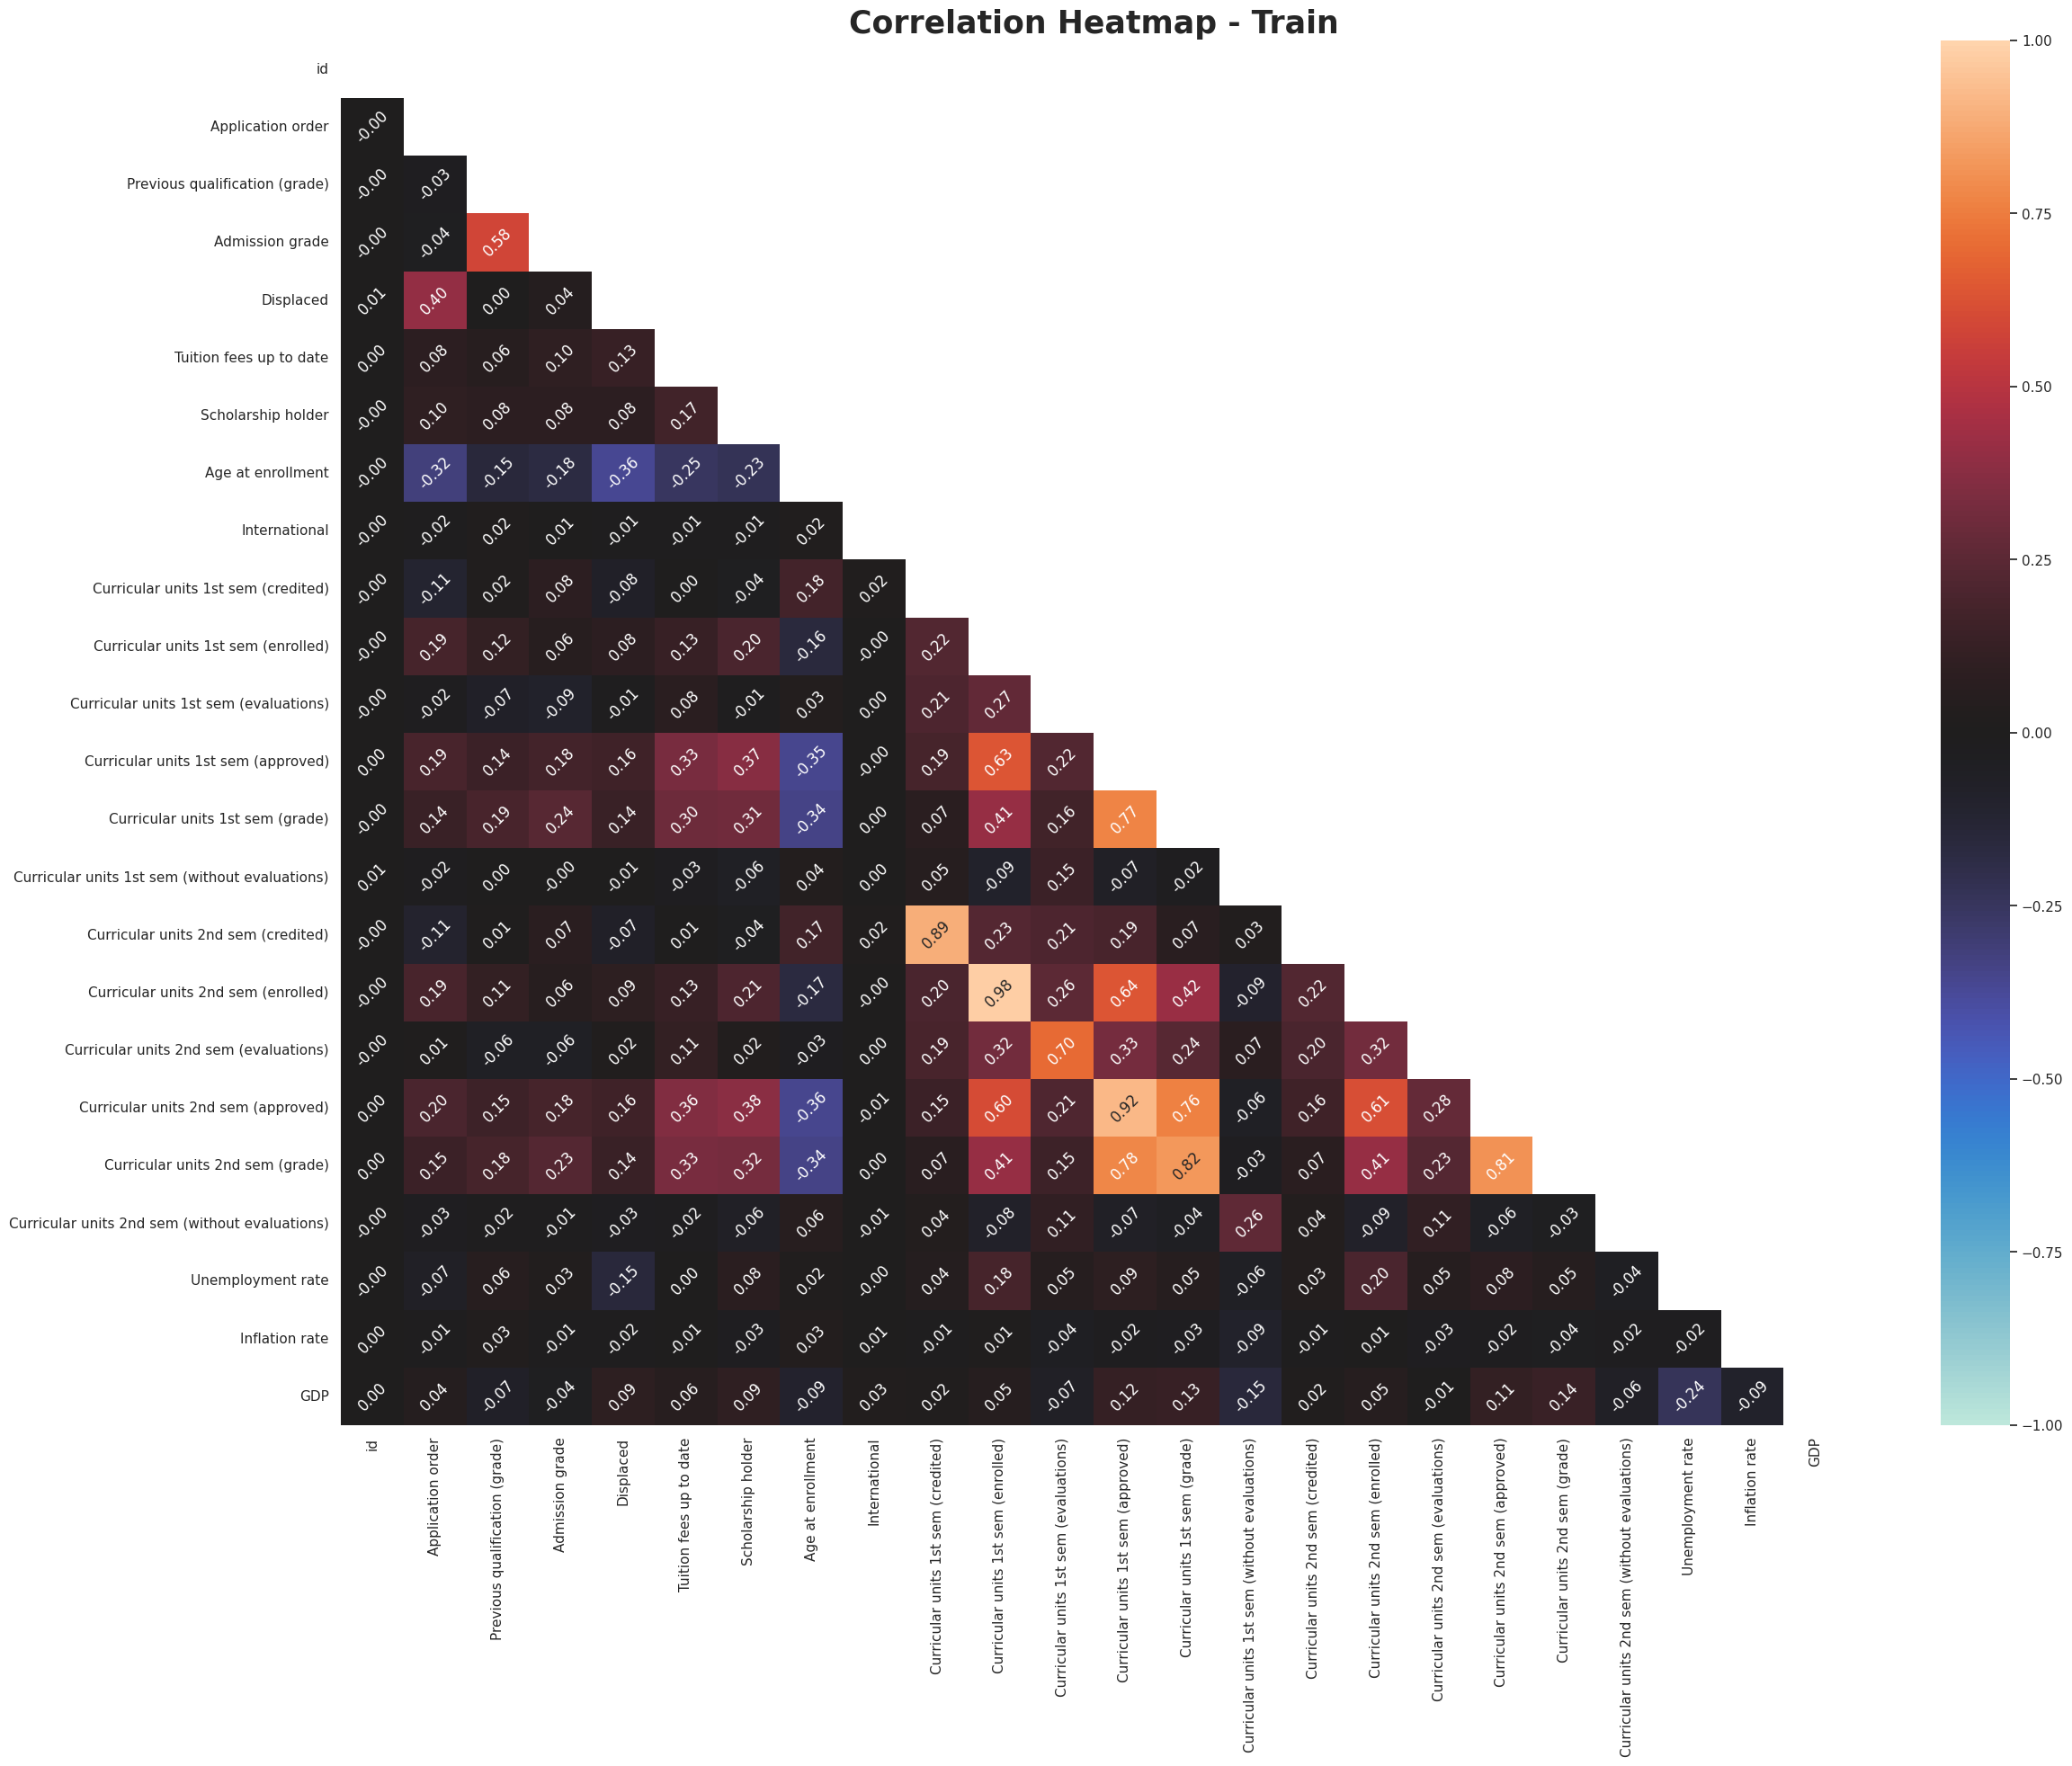

In [29]:
plot_correlation(train, 'Train')

## EDA(Numeric Fields) ##

In [30]:


def plot_numerical():
    #num = train.select_dtypes(include=['int64','float64']).columns

    df = pd.concat([train[NUMERIC_COLS].assign(Source = 'Train'),
                    test[NUMERIC_COLS].assign(Source = 'Test')], ignore_index = True)

    # Use of more advanced artistic matplotlib interface (see the axes)
    fig, axes = plt.subplots(len(NUMERIC_COLS), 3 ,figsize = (16, len(NUMERIC_COLS) * 4),
                             gridspec_kw = {'hspace': 0.35, 'wspace': 0.3,
                                            'width_ratios': [0.80, 0.20, 0.20]})

    for i,col in enumerate(NUMERIC_COLS):
        ax = axes[i,0]
        sns.kdeplot(data = df[[col, 'Source']], x = col, hue = 'Source', palette=['#456cf0', '#ed7647'], linewidth = 2.1, warn_singular=False, ax = ax) # Use of seaborn with artistic interface
        ax.set_title(f"\n{col}",fontsize = 9)
        ax.grid(visible=True, which = 'both', linestyle = '--', color='lightgrey', linewidth = 0.75)
        ax.set(xlabel = '', ylabel = '')

        ax = axes[i,1]
        sns.boxplot(data = df.loc[df.Source == 'Train', [col]], y = col, width = 0.25, linewidth = 0.90, fliersize= 2.25, color = '#456cf0', ax = ax)
        ax.set(xlabel = '', ylabel = '')
        ax.set_title("Train", fontsize = 9)

        ax = axes[i,2]
        sns.boxplot(data = df.loc[df.Source == 'Test', [col]], y = col, width = 0.25, linewidth = 0.90, fliersize= 2.25, color = '#ed7647', ax = ax)
        ax.set(xlabel = '', ylabel = '')
        ax.set_title("Test", fontsize = 9)

    plt.suptitle(f'\nDistribution analysis - numerical features',fontsize = 12, y = 0.89, x = 0.57, fontweight='bold')
    plt.show()

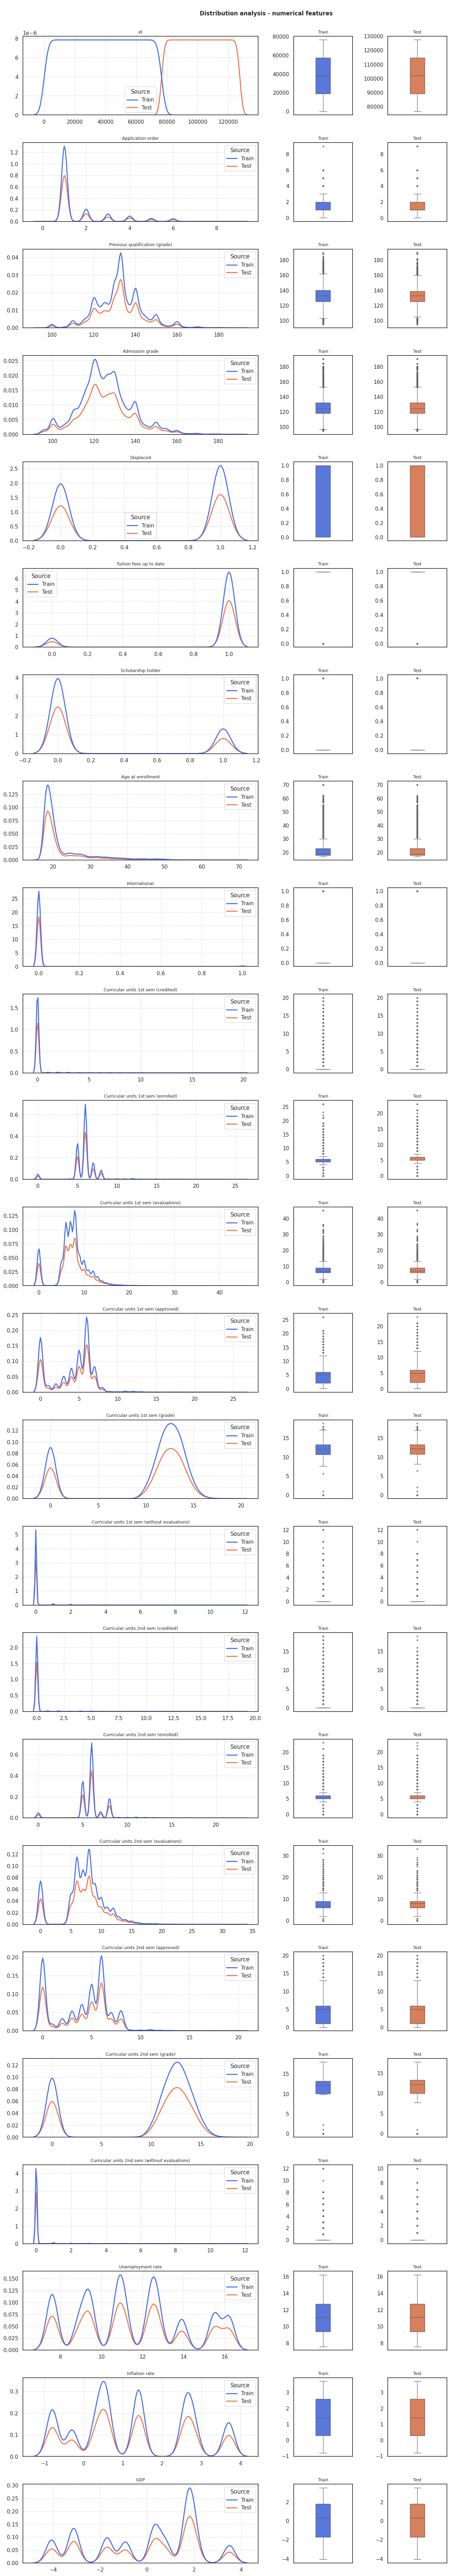

In [31]:
plot_numerical()

### Categorical field plots ###

In [32]:
def plot_cat(limit_unique=20):
    selectcols = train[CAT_COLS].nunique()<=limit_unique
    cols_ = selectcols[selectcols].index.to_list()
    n_cols = len(cols_)
    fig, ax = plt.subplots(n_cols, 2, figsize=(12, 4 * n_cols))
    for i, coluna in enumerate(cols_):
        sns.countplot(x=train[coluna], ax=ax[i, 0])
        ax[i, 0].set_title(f'{coluna}')
        ax[i, 0].set_ylabel('Count')
        ax[i, 0].set_xlabel(coluna)
        ax[i, 0].tick_params(axis='x', labelrotation=45)

        for container in ax[i, 0].containers:
            ax[i, 0].bar_label(container, fmt='%d', label_type='center', rotation=90)


        s1 = train[coluna].value_counts()

        textprops = {
            'size':8,
            'weight': 'bold',
            'color':'white'
        }

        ax[i, 1].pie(s1,
            autopct='%1.f%%',
            pctdistance=0.8,
            textprops=textprops,
            labels=train[coluna].value_counts().index
        )
        ax[i, 1].set_title(f'% {coluna}')

    plt.tight_layout()
    plt.show()

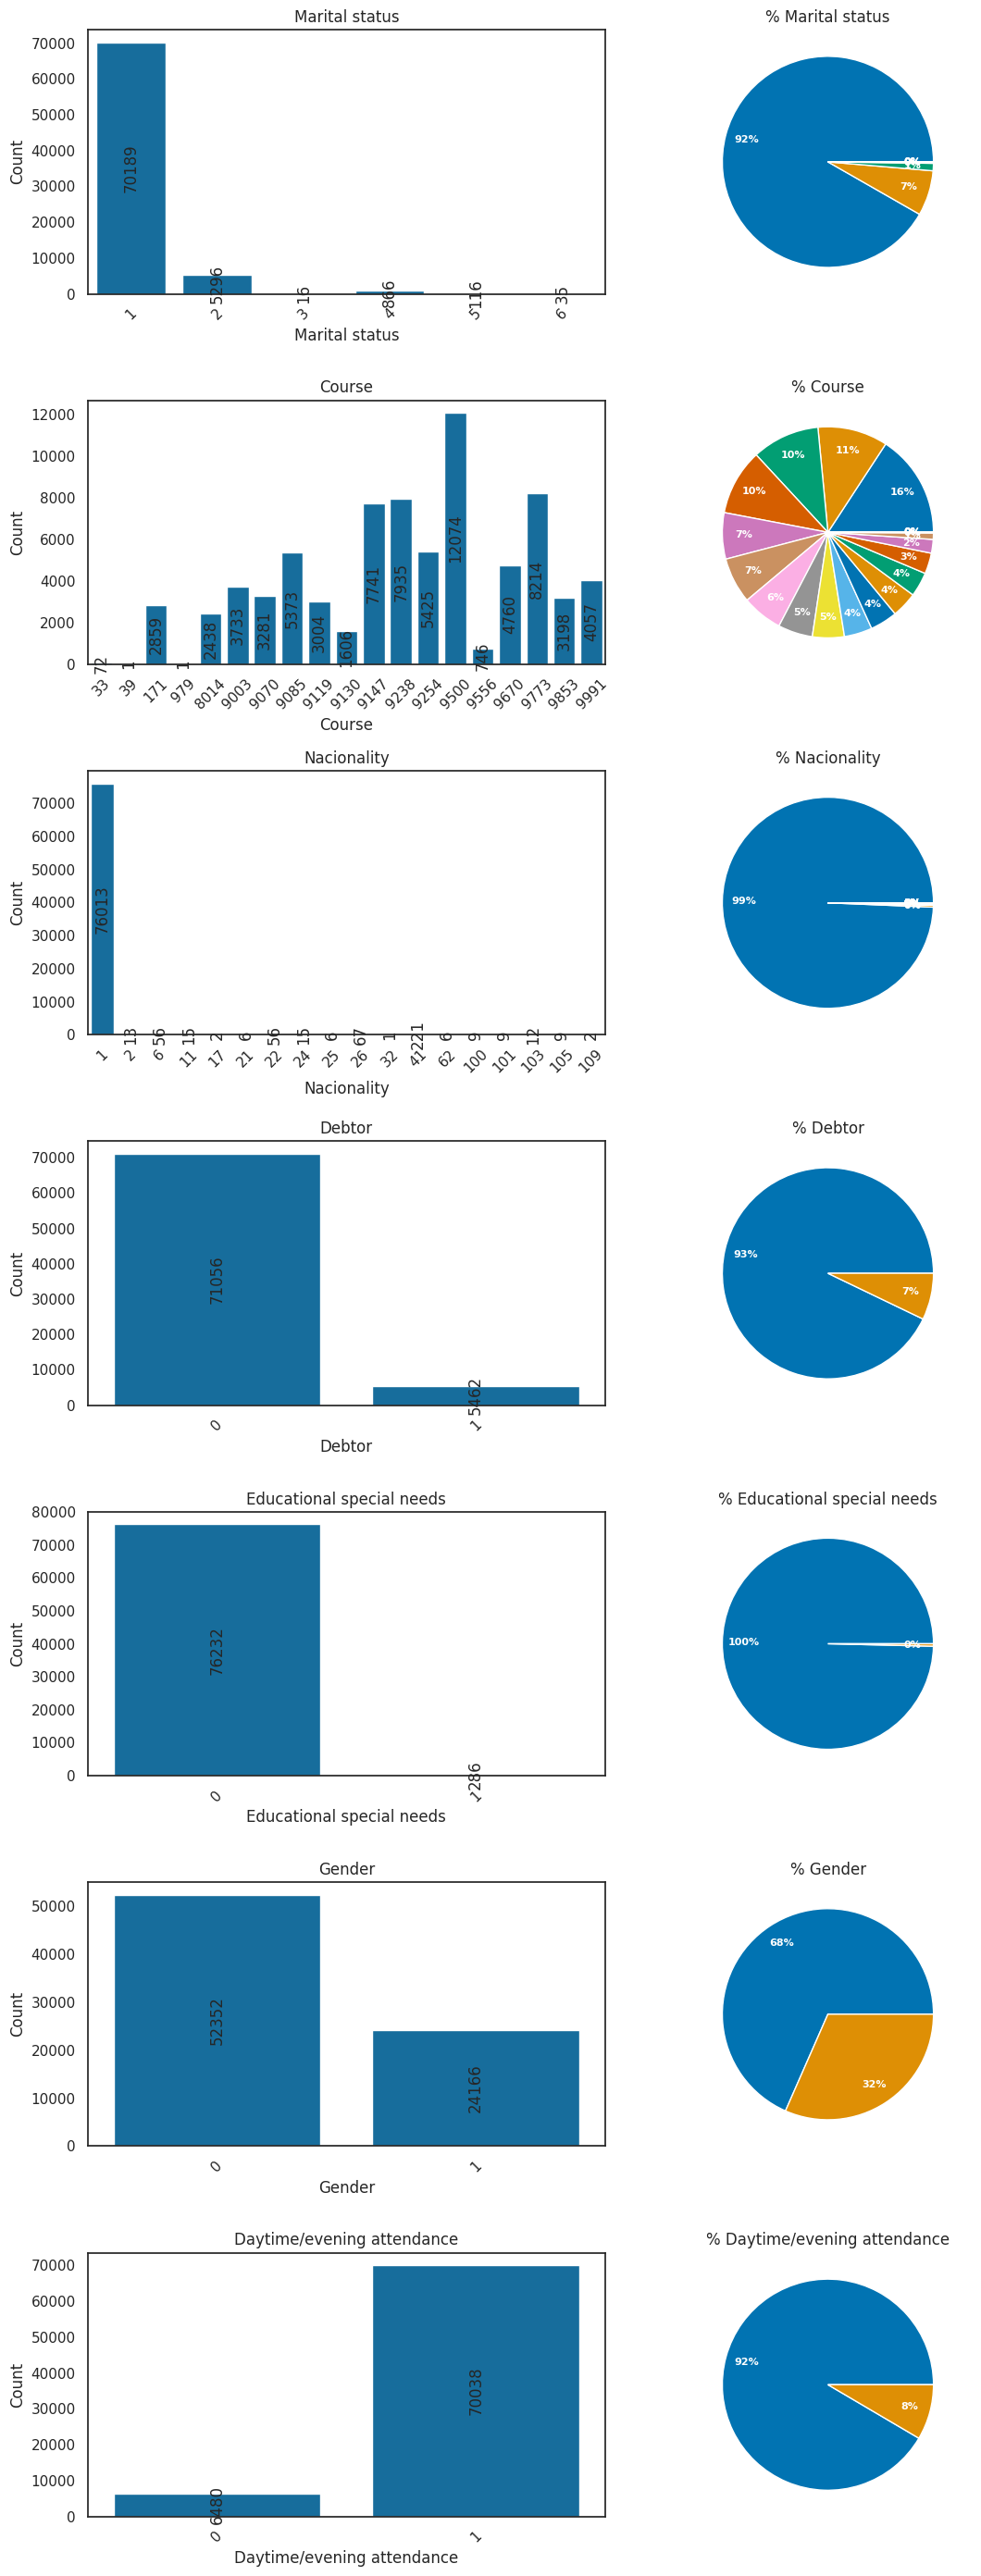

In [33]:
plot_cat()

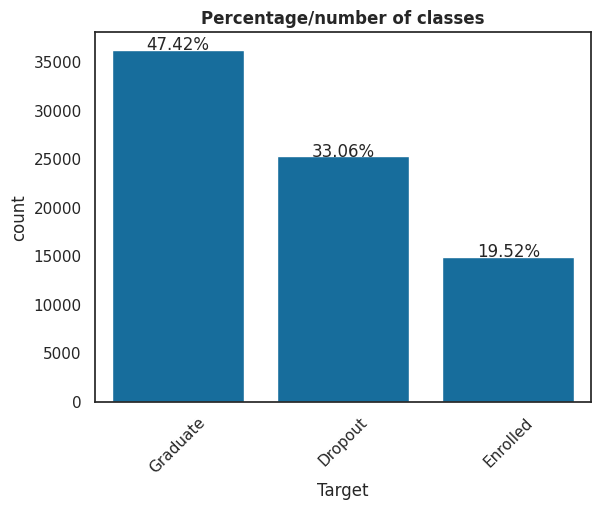

In [34]:
ax = sns.countplot(x=train[TARGET])

total = len(train[TARGET])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 0.1,
            '{:.2%}'.format(height / total),
            ha="center")
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.title('Percentage/number of classes',fontweight='bold')
plt.show()

## Cross Valdidation ##

### Configs ###

In [35]:
SUBMIT = False
SEED = 42
USE_ORIGINAL = False

In [36]:
scores, oof, test_predictions = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
lblTarget = LabelEncoder()
train[TARGET] = lblTarget.fit_transform(train[TARGET])
kf = StratifiedKFold(n_splits=5,random_state=SEED,shuffle=True)
oof_proba = np.zeros((len(train),3))

In [37]:
def score_model(estimator, label = '', verbose=False):

    X = train.copy()
    y = X.pop(TARGET)

    val_predictions = np.zeros((len(X)))
    test_predictions = np.zeros((len(test)))
    val_scores= []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):


        model = clone(estimator)
        if isinstance(model, CatBoostClassifier):
            model.set_params(cat_features=CAT_COLS)

        X_train = X.iloc[train_idx].reset_index(drop = True)
        y_train = y.iloc[train_idx].reset_index(drop = True)

        X_val = X.iloc[val_idx].reset_index(drop = True)
        y_val = y.iloc[val_idx].reset_index(drop = True)

        if USE_ORIGINAL:
            X_train = pd.concat([X_train, original.drop([TARGET],axis=1)])
            y_train = pd.concat([y_train,original[TARGET]])

        model.fit(X_train, y_train)
        val_preds = model.predict(X_val)
        val_predictions[val_idx] += val_preds.ravel()
        oof_proba[val_idx] += model.predict_proba(X_val)

        val_score = accuracy_score(y_val, val_preds)
        val_scores.append(val_score)
        if verbose:
            print(f'Fold {fold+1}: {val_score:.5f}')

    if SUBMIT:
        X_train = train.copy()
        y_train = X_train.pop(TARGET)
        model.fit(X_train,y_train)
        test_predictions = model.predict_proba(test)

    printColor(f'Val Score: {np.mean(val_scores):.5f} ± {np.std(val_scores):.5f} | {label}')


    return val_scores, val_predictions, test_predictions

### Models ###

In [38]:
models = [
    ('cb', CatBoostClassifier(random_state=SEED,cat_features=CAT_COLS, verbose=0)),
    ('rf', RandomForestClassifier(random_state=SEED)),
    ('et', ExtraTreesClassifier(random_state=SEED)),
    ('xgb', XGBClassifier(random_state=SEED)),
    ('lgb', LGBMClassifier(random_state=SEED, verbose=-1)),
    ('dart', LGBMClassifier(random_state=SEED, boosting_type='dart', verbose=-1)),
    ('gb', GradientBoostingClassifier(random_state=SEED)),
    ('hgb', HistGradientBoostingClassifier(random_state=SEED))

]

for (label, model) in models:
  if isinstance(model, CatBoostClassifier):
    scores[label], oof[label], test_predictions[label] = score_model(model, label)
  else:
    scores[label], oof[label], test_predictions[label] = score_model(make_pipeline(ce.MEstimateEncoder(cols=CAT_COLS), model), label)


Val Score: 0.83205 ± 0.00150 | cb
Val Score: 0.82560 ± 0.00232 | rf
Val Score: 0.82475 ± 0.00148 | et
Val Score: 0.83047 ± 0.00184 | xgb
Val Score: 0.83139 ± 0.00170 | lgb
Val Score: 0.82814 ± 0.00209 | dart
Val Score: 0.82754 ± 0.00153 | gb
Val Score: 0.83052 ± 0.00160 | hgb


## Ensemble ##

In [40]:
y_pred = oof.mode(axis=1)[0].astype(int)
scores['ensemble'] = accuracy_score(train[TARGET], y_pred)

## Scores ##

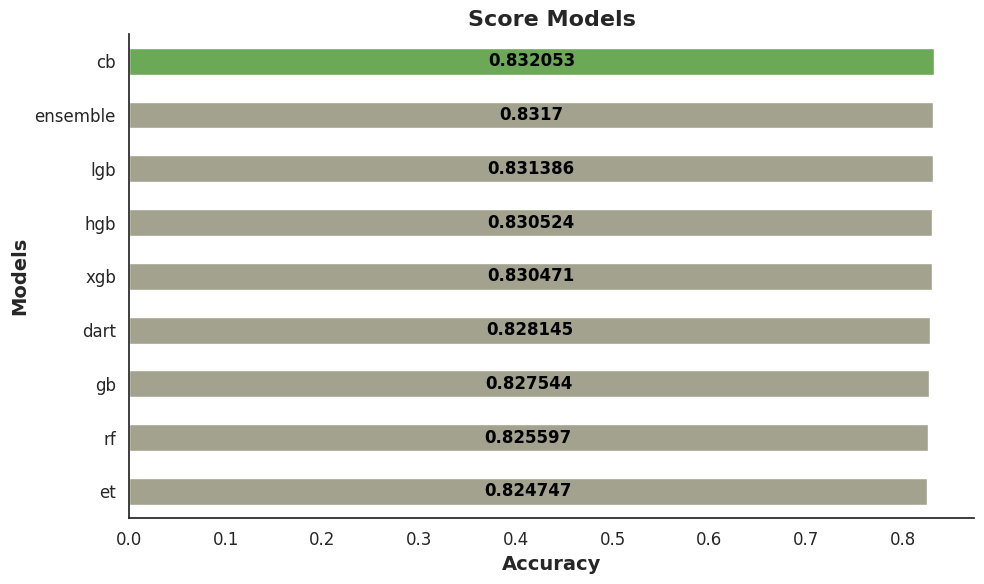

In [41]:
ax = scores.mean().sort_values(ascending=True).plot(kind='barh', figsize=(10, 6), color='#a2a28f')

for container in ax.containers:
    ax.bar_label(container, label_type='center', color='black', fontsize=12, fontweight='bold')
ax.patches[-1].set_facecolor('#6ca957')

ax.set_title('Score Models', fontsize=16, fontweight='bold')

ax.set_xlabel('Accuracy', fontsize=14, fontweight='bold')
ax.set_ylabel('Models', fontsize=14, fontweight='bold')

ax.tick_params(axis='both', which='major', labelsize=12)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()